# Maximun a Posteriori Training for Kernel Adaptive Filters

## Model
### Likelihood
$$p(X|\theta) = \prod_{t=1}^N \frac{1}{\sqrt{2\pi\sigma_e^2}} \exp\left( -\frac{\left(y_t - \sum_{i=1}^{\left|D_t\right|}\alpha_i k (x_t, s_i)\right)^2}{2\sigma_e^2} \right)$$

in other words,

$$p(x_t|\theta) \sim \mathcal{N} \left(\sum_{i=1}^{\left|D_t\right|} \alpha_i \exp\left(-\frac{\left\|x_t - s_i\right\|^2}{2\sigma_k^2}\right), \sigma_e^2 \right)$$

### Dictionary Prior
$$p(D) = \frac{1}{\sqrt{2\pi l^2}} \exp \left( -\frac{\left\|k(D_t, D_t)\right\|^2}{2l^2} \right)$$

### Hyperparamter Priors
- $\alpha_i \sim \mathcal{N}(0,\sigma_\alpha)$
- $l \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\sigma_k \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\sigma_e \sim \mathcal{N}(0, 1.0)$ or $U_{[\mathbb{R}^+]}$
- $\log\left(p(D_t)\right) = \frac{1}{2}\log(2\pi l^2) - \frac{1}{2l^2}\left\|k_{\sigma_k}(D, D) \right\|$

## PyMC 3 Implementation
### Load Data (Lorentz Chaotic Series)

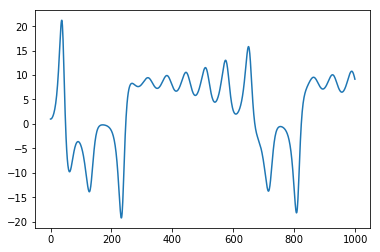

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
data = np.load('./data.npy')[0]  #  Only load 'x' dimension

plt.plot(data)

### Model Definitions

In [11]:
import theano
import theano.tensor as tt

def logp_mean(x, sv, alpha, sigma_k):
    """ Mean of Likelihood Model """
    #return np.dot(alpha, kern_mat(x, sv, sigma_k).T)
    return np.dot(kern_mat(x, sv, sigma_k), alpha)

def kern_mat(x, sv, sigma_k):
    """ kernel(x ,s) where |x| != |s| """
    return np.exp(-1/(2*sigma_k**2)*np.add.outer(x, -sv)**2)

def logp_d(sv, sigma_l, sigma_k):
    """ Log-Prior of Dictionary """
    return -0.5*tt.log(2*np.pi*sigma_l**2) - 1/(2*sigma_l**2)*(norm_gram(sv, sigma_k)**2)

def norm_gram(sv, sigma_k):
    """ Norm of Gram Matrix of Dictionary """
    return tt.sum(tt.exp(-1/(2*sigma_k**2)*np.subtract.outer(sv, sv)**2))    

### PyMC3 Sampling

In [18]:
from pymc3 import (Model, Normal, HalfNormal, Uniform, Flat, Potential, 
                   Slice, Metropolis, sample, traceplot, find_MAP)

adaptive_model = Model()

dict_size = 999
x = data[0:dict_size]
y = data[1:dict_size+1]

with adaptive_model:
    sigma_e = HalfNormal('sigma_e', sd=100.)
    sigma_k = HalfNormal('sigma_k', sd=100.)
    sigma_l = HalfNormal('sigma_l', sd=100.)
    
    s = Uniform('s', np.min(x), np.max(x), shape=dict_size)
    a = Normal('a', sd=10, shape=dict_size)
    
    tx = theano.shared(np.asarray(x, dtype=theano.config.floatX))
    
    logp_dict = Potential('logp_dict', logp_d(s, sigma_l, sigma_k))
    mu = logp_mean(tx, s, a, sigma_k)
    logp_like = Normal('like', mu=mu, sd=sigma_e, observed=y)
    
    step = Metropolis()
    trace = sample(5000, step)

100%|██████████| 5000/5000 [00:07<00:00, 703.85it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0eab48588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc0fbfdbcf8>]], dtype=object)

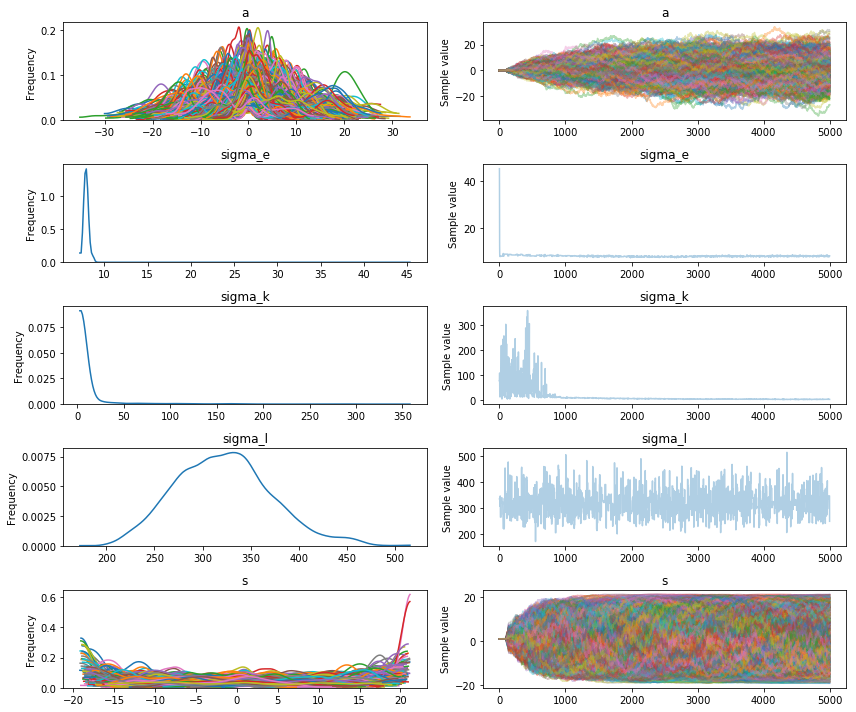

In [19]:
traceplot(trace)

In [20]:
map_params = find_MAP(model=adaptive_model)
print(map_params)

         Current function value: -14026.967681
         Iterations: 5159
         Function evaluations: 5778
         Gradient evaluations: 5766
{'sigma_e_log_': array(-20.7849837727124), 'sigma_k_log_': array(3.3900751748937314), 'sigma_l_log_': array(5.656434386261159), 's_interval_': array([ -1.05063499e-01,  -6.31949757e-02,  -1.19087413e-01,
         4.95419460e-02,  -1.38532288e-01,   8.62675440e-02,
         1.79103317e-01,   1.28507525e-01,  -1.58578594e-01,
        -5.03042072e-02,   5.59968593e-02,  -5.57340964e-02,
        -1.42651068e-01,  -5.08816405e-02,  -2.85217724e-02,
        -1.78521317e-01,  -6.76392624e-02,   4.19619301e-01,
         1.23213835e+00,   2.39482774e+00,   2.83410509e-01,
         7.14171230e-01,   7.28261229e-01,  -2.23462475e-01,
         2.55060995e-01,  -8.83444129e-01,  -1.78806874e+00,
        -4.23982483e-01,   4.04738307e-01,  -2.49024937e+00,
         2.44688881e-01,  -7.76007158e-02,   1.04079877e+00,
        -2.00344205e+00,   1.22262068e+01

In [21]:
print(map_params.keys())

dict_keys(['sigma_e_log_', 'sigma_k_log_', 'sigma_l_log_', 's_interval_', 'a'])


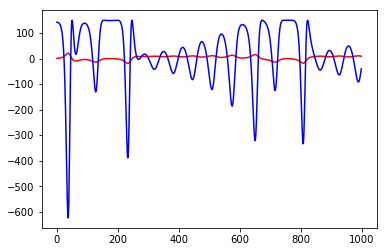

In [25]:
y_estimate = logp_mean(x, map_params['s_interval_'], map_params['a'], np.exp(map_params['sigma_k_log_'])) - 3000

plt.plot(x, 'r')
plt.plot(y_estimate, 'b')

In [ ]:
# WHITEBOARD CELL, funciones que usé o podría usar eventualmente

def gram(x1, x2):
    return x1[:, 1].dimshuffle([0, 'x', 1]) - x2[:, 1].dimshuffle(['x', 0, 1])

#def logp_mean(x, sv, alpha, sigma_k):
    """ 
    N >= n
    x: shape(N,1)
    sv: shape(n, 1)
    alpha: shape(n, 1)
    return: shape(N, 1)
    """
#    return tt.dot(alpha, kern_mat(x, sv, sigma_k).T)

#def kern_mat(x, sv, sigma_k):
#    return tt.exp(-1/(2*sigma_k**2)*np.subtract.outer(x, sv)**2)
    # return tt.exp(-1/(2*sigma_k**2)*gram(x, sv)**2)
    
#0.5*T.log(2*np.pi*l**2) - 1/(2*l**2)*T.sum(T.exp(-1/(2*sigma_k**2)*np.subtract.outer(value, value))**2))
